In [1]:
from __future__ import print_function

import segmentation_models as sm

import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'
%matplotlib inline
import seaborn as sns

import keras
from keras import metrics
from keras.datasets import mnist
from keras.models import Sequential
from keras.optimizers import RMSprop, SGD
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from keras.models import model_from_json
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, precision_score, recall_score, log_loss, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score, accuracy_score

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [350]:
output_path = "./trained_FPN_epoch100_data_trainset_20190717"
prediction_path = "./prediction_FPN_epoch100_data_trainset_20190717"

#traininig parameters
batch_size = 1
epochs = 100
LR = 1
BACKBONE = 'resnet18'

In [342]:
# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
#    CLASSES = ['nonfrac', 'frac']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
#        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
#        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # yao_added
#        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
#        masks = [(mask == v) for v in self.class_values]
        masks = [(mask == 255)] # the fracture loc was labeled with 255, yao_added
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        image= np.stack([image], axis = 2) # yao_added, fix dimension
        
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

In [343]:
import albumentations as A

def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [
        A.PadIfNeeded(min_height=32*32, min_width=32*32, always_apply=True, border_mode=0),
#        A.RandomCrop(height=32*32, width=32*32, always_apply=True),
    ]
    return A.Compose(train_transform)

In [348]:
preprocess_input = sm.get_preprocessing(BACKBONE)

from segmentation_models import Unet
#model = Unet(encoder_weights=None, classes=1,input_shape=(640, 640,1))

#create model
model = sm.FPN(BACKBONE, classes=1, activation='sigmoid', input_shape=(None, None, 1), encoder_weights=None)
model.summary()
model.compile(keras.optimizers.SGD(LR) ,
              loss='binary_crossentropy',
              metrics=['acc'])
 #             metrics=[sm.metrics.iou_score])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, None, None, 1 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 1 3           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_505 (ZeroPadding (None, None, None, 1 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 3136        zero_padding2d_505[0][0]         
__________________________________________________________________________________________________
bn0 (Batch

(1024, 1024, 1)
255
(1024, 1024, 1)
1.0


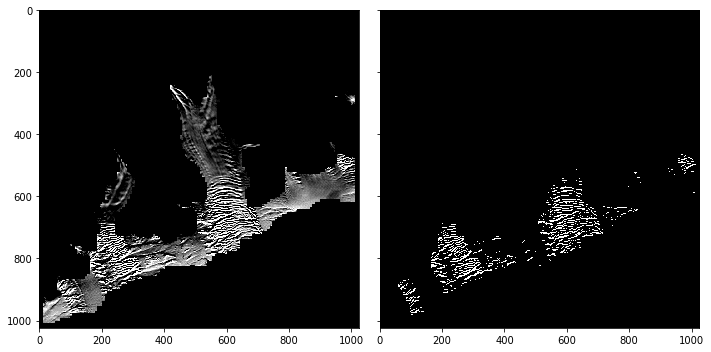

In [347]:
# Dataset for train images
x_train_dir = './data_trainset_20190717/train'
y_train_dir = './data_trainset_20190717/trainlabel'

train_dataset = Dataset(
    x_train_dir, 
    y_train_dir,  
    augmentation=get_training_augmentation(),
)
train_dataloader = Dataloder(train_dataset, batch_size=batch_size, shuffle=True)
    
print(image.shape)
print(max(image[...].flatten()))
print(mask.shape)
print(max(mask.flatten()))

In [349]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=epochs
)

Epoch 1/100
26/26 [==============================] - 550s 21s/step - loss: 0.1288 - acc: 0.9649
Epoch 2/100
26/26 [==============================] - 513s 20s/step - loss: 0.0990 - acc: 0.9939
Epoch 3/100
26/26 [==============================] - 513s 20s/step - loss: 0.0990 - acc: 0.9939
Epoch 4/100
26/26 [==============================] - 513s 20s/step - loss: 0.0986 - acc: 0.9939
Epoch 5/100
26/26 [==============================] - 514s 20s/step - loss: 0.0890 - acc: 0.9939
Epoch 6/100
26/26 [==============================] - 513s 20s/step - loss: 0.0643 - acc: 0.9939
Epoch 7/100
26/26 [==============================] - 513s 20s/step - loss: 0.0571 - acc: 0.9939
Epoch 8/100
26/26 [==============================] - 507s 19s/step - loss: 0.0405 - acc: 0.9939
Epoch 9/100
26/26 [==============================] - 506s 19s/step - loss: 0.0257 - acc: 0.9939
Epoch 10/100
26/26 [==============================] - 506s 19s/step - loss: 0.0206 - acc: 0.9939
Epoch 11/100
26/26 [===================

26/26 [==============================] - 518s 20s/step - loss: 0.0103 - acc: 0.9958
Epoch 86/100
26/26 [==============================] - 516s 20s/step - loss: 0.0074 - acc: 0.9970
Epoch 87/100
26/26 [==============================] - 511s 20s/step - loss: 0.0062 - acc: 0.9975
Epoch 88/100
26/26 [==============================] - 511s 20s/step - loss: 0.0061 - acc: 0.9975
Epoch 89/100
26/26 [==============================] - 511s 20s/step - loss: 0.0061 - acc: 0.9974
Epoch 90/100
26/26 [==============================] - 517s 20s/step - loss: 0.0056 - acc: 0.9978
Epoch 91/100
26/26 [==============================] - 670s 26s/step - loss: 0.0050 - acc: 0.9981
Epoch 92/100
26/26 [==============================] - 822s 32s/step - loss: 0.0048 - acc: 0.9982
Epoch 93/100
26/26 [==============================] - 527s 20s/step - loss: 0.0047 - acc: 0.9982
Epoch 94/100
26/26 [==============================] - 548s 21s/step - loss: 0.0047 - acc: 0.9982
Epoch 95/100
26/26 [=======================

In [351]:
## SAVE MODEL
import os

# detect the current working directory and print it
os.mkdir(output_path)
os.chdir(output_path)

# serialize model to JSON
model_json = model.to_json()
with open(output_path + "model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(output_path + "model.h5")
print("Saved model to disk")

os.chdir('/home/yao/Downloads/segmentation_models-master/examples') # back to example directory

Saved model to disk


Text(0.5, 1.0, 'Training and validation loss')

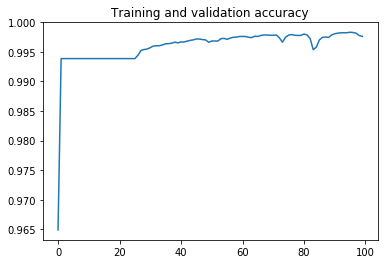

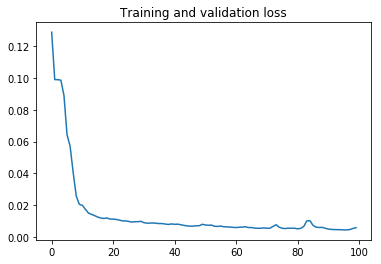

In [352]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']

plt.plot(range(len(acc)), acc)
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(range(len(loss)), loss)
plt.title('Training and validation loss')

## Test performance

In [353]:
# Dataset for test images
x_test_dir = './data_testset_random_20190812/test'
y_test_dir = './data_testset_random_20190812/testlabel'

test_dataset = Dataset(
    x_test_dir, 
    y_test_dir,  
    augmentation=get_training_augmentation(),
)
test_x=[]
test_y=[]
for i in range (0,6):
    image, mask = test_dataset[i] # get some sample
    test_x.append(image)
    test_y.append(mask)

test_x=np.array(test_x)
test_y=np.array(test_y)

In [354]:
# prediction
prediction = model.predict(test_x)
prediction = np.array(prediction)

test_y_ = test_y.flatten()
test_y_predict = prediction.flatten()
print(max(test_y_predict))
print(min(test_y_predict))
print(max(test_y_))
print(min(test_y_))

0.9535363
0.0
1.0
0.0


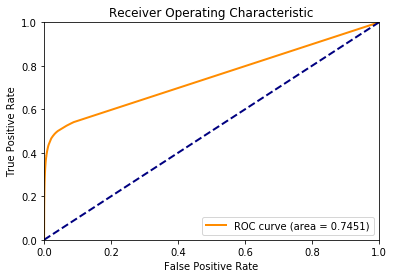

AUC =  0.7451432428212805


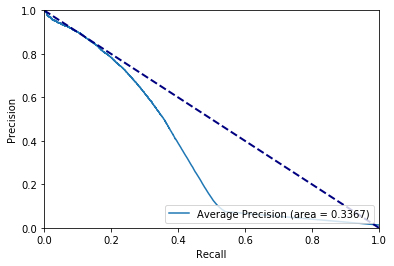

AP =  0.336740174744636


In [355]:
fpr, tpr, thresholds = roc_curve(test_y_,test_y_predict)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label = 'ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw=lw, linestyle = '--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.show()
print('AUC = ',roc_auc)

precision, recall, thresholds = precision_recall_curve(test_y_, test_y_predict)
AP = average_precision_score(test_y_, test_y_predict)
plt.figure()
plt.plot(recall, precision, label = 'Average Precision (area = %0.4f)' % AP)
plt.plot([0, 1], [1, 0], color = 'navy', lw=lw, linestyle = '--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc = 'lower right')
plt.show()
print('AP = ',AP)

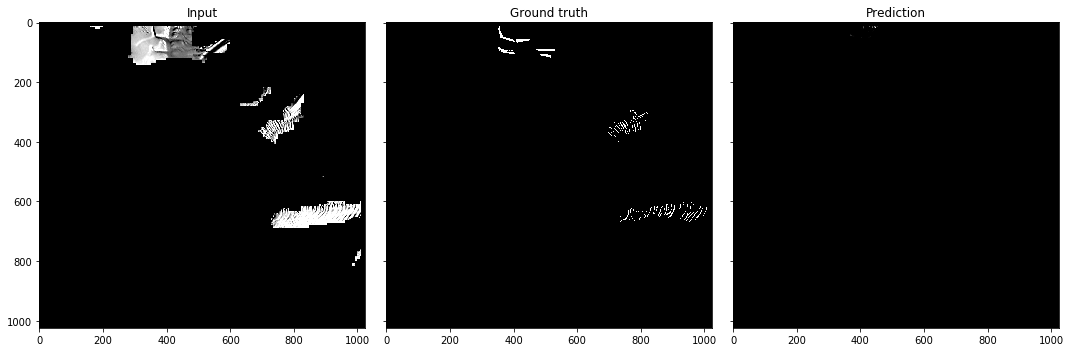

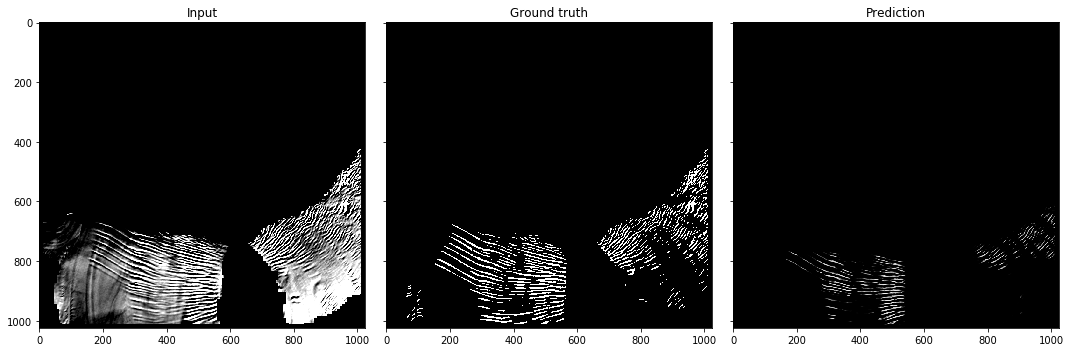

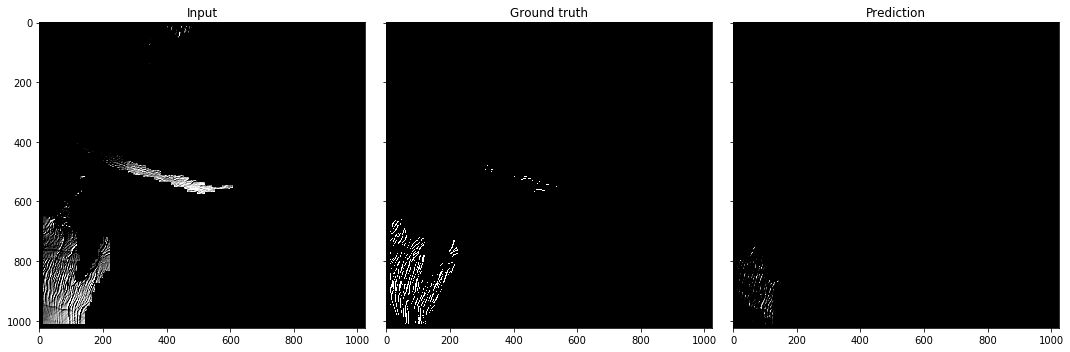

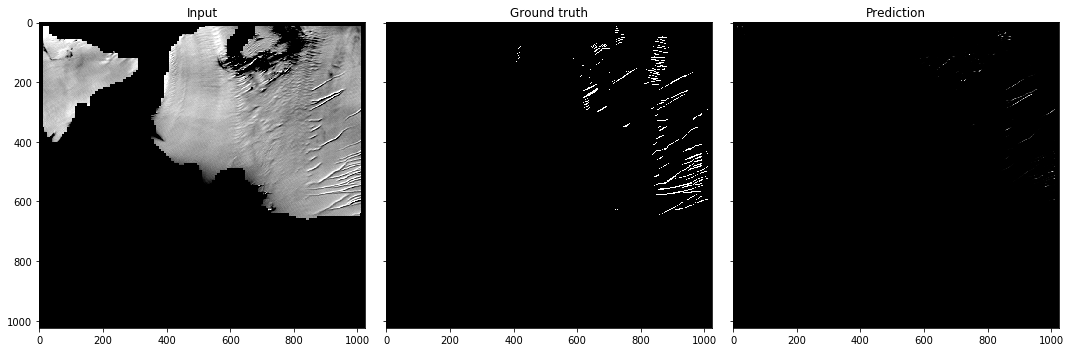

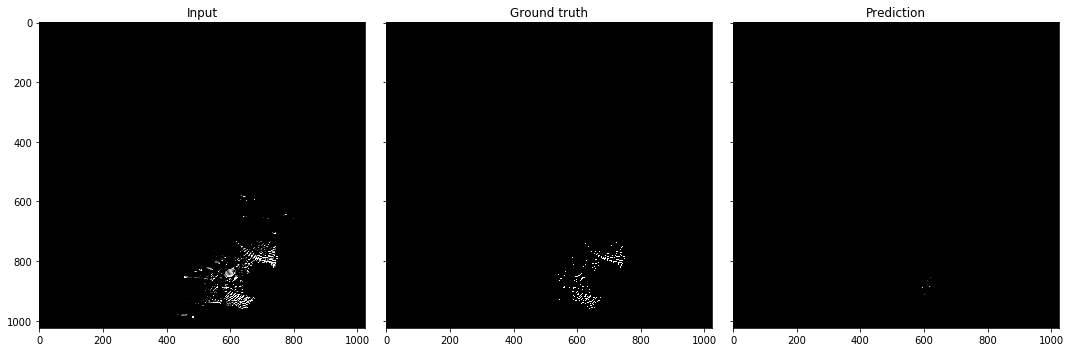

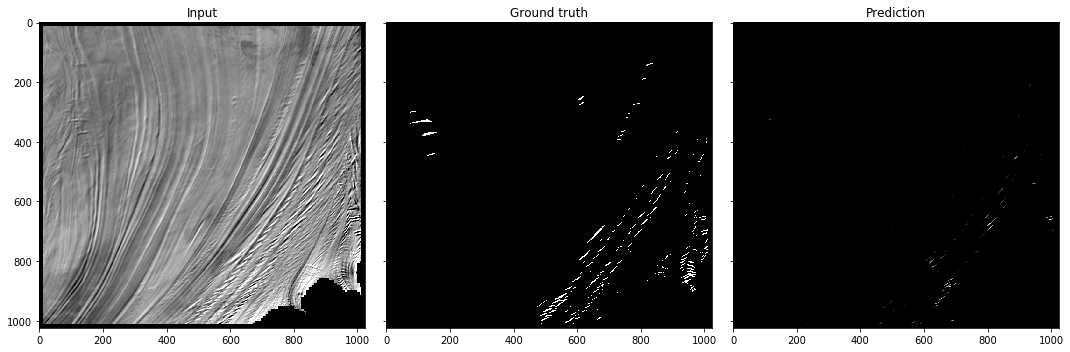

In [356]:
# display
for i in range(0,6):
    fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,5))
    ax[0].imshow(test_x[i,...,0], aspect="auto")
    ax[1].imshow(test_y[i,...,0], aspect="auto")
    ax[2].imshow(prediction[i,...,0], aspect="auto")
    ax[0].set_title("Input")
    ax[1].set_title("Ground truth")
    ax[2].set_title("Prediction")
    fig.tight_layout()

## Tes on Ross Ice Shelf

In [357]:
# load json and create model
os.chdir(output_path) #go to model directory

json_file = open(output_path + 'model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(output_path + "model.h5")
print("Loaded model from disk")

os.chdir('/home/yao/Downloads/segmentation_models-master/examples') # back to example directory

Loaded model from disk


In [358]:
# Dataset for test images
x_test_dir = './data_ross/test'
y_test_dir = './data_ross/testlabel'

test_dataset = Dataset(
    x_test_dir, 
    y_test_dir,  
    augmentation=get_training_augmentation(),
)
test_x=[]
test_y=[]
for i in range (0,2):
    image, mask = test_dataset[i] # get some sample
    test_x.append(image)
    test_y.append(mask)
test_x=np.array(test_x)
test_y=np.array(test_y)

#prediction = loaded_model.predict(test_x)
prediction = model.predict(test_x)
prediction = np.array(prediction)

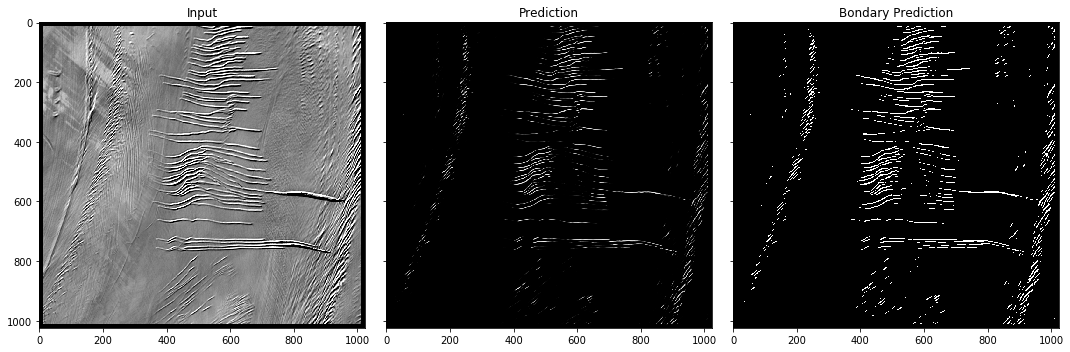

In [363]:
# display
i=1#sample index
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,5))
ax[0].imshow(test_x[i,...,0], aspect="auto")
ax[1].imshow(prediction[i,...,0], aspect="auto")
mask = prediction[i,...,0] > 0.05
ax[2].imshow(mask, aspect="auto")
ax[0].set_title("Input")
ax[1].set_title("Prediction")
ax[2].set_title("Bondary Prediction")
fig.tight_layout()